In [1]:
import os
import time
import math

import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import torch

%matplotlib inline

In [2]:
os.getcwd()

'/home/patrick/NLP'

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3090


In [4]:
# Read in Dynamically-Generated-Hate-Dataset v0.2.3 file
fpath = r"DGHatev0_2_3.csv"
dgh = pd.read_csv(fpath)

### Exploratory Data Analysis

In [5]:
dgh.head()

,Unnamed: 0,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
0,1,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
1,2,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
2,3,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN
3,4,acl1000,4,I'm not saying we should actually eliminate he...,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN
4,5,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN


In [6]:
dgh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41144 entries, 0 to 41143
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      41144 non-null  int64 
 1   acl.id          41144 non-null  object
 2   X1              41144 non-null  int64 
 3   text            41144 non-null  object
 4   label           41144 non-null  object
 5   type            41144 non-null  object
 6   target          41136 non-null  object
 7   level           41144 non-null  object
 8   split           41144 non-null  object
 9   round.base      41144 non-null  int64 
 10  annotator       41144 non-null  object
 11  round           41144 non-null  object
 12  acl.id.matched  30098 non-null  object
dtypes: int64(3), object(10)
memory usage: 4.1+ MB


Text(0.5, 1.0, 'Sentences for each language')

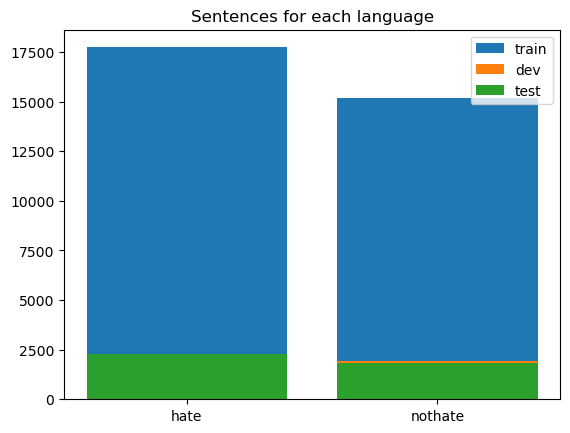

In [7]:
# Show distribution of sentences
categories = dgh.label.value_counts().index
counts_train = dgh[dgh['split']=='train'].label.value_counts().values
counts_test = dgh[dgh['split']=='test'].label.value_counts().values
counts_dev = dgh[dgh['split']=='dev'].label.value_counts().values
plt.bar(categories, counts_train, label='train')
plt.bar(categories, counts_dev, label='dev')
plt.bar(categories, counts_test, label='test')
plt.legend(loc='best')
plt.title('Sentences for each language')

In [8]:
dgh.label.value_counts().values

array([22175, 18969])

The dataset has 22,175 hate speech examples and 18,969 non-hate speech examples, so the dataset is slightly imbalanced. However, it appears there is not an equal proportion of hate speech examples in the 'dev' dataset, so it seems worthwhile to re-distribute the splits.

In [9]:
# Calculate number of words in each sentence
dgh['count'] = dgh.text.str.split().str.len()
# Calculate average sentence length for each language group
avg_len_dgh = dgh.groupby(['label','split'])['count'].mean()

In [10]:
print(avg_len_dgh)
print(f"Overall average sentence length is {avg_len_dgh.mean():.2f} words.")

label    split
hate     dev      23.963083
         test     21.330247
         train    24.009526
nothate  dev      24.793585
         test     25.884449
         train    24.988936
Name: count, dtype: float64
Overall average sentence length is 24.16 words.
